# Preamble

It's customary to put all the imports in the beginning of the file. Various helper functions may also appear here.

In [1]:
import pandas as pd
import numpy as np
from math import sqrt

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, RidgeCV, Ridge, LassoCV, Lasso

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

## Loading and inspecting data

We load the data from CSV as a Pandas data frame. It's the obvious first step to inspect what we have.

In [2]:
hitters = pd.read_csv('Hitters.csv')
hitters

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,N,E,325,9,3,700.0,N
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,A,E,313,381,20,875.0,A
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,A,W,37,113,7,385.0,A
320,573,144,9,85,60,78,8,3198,857,97,470,420,332,A,E,1314,131,12,960.0,A


## Preparing data

We immediately see a salary that is NaN (typically signifying that the information is unavailable). We can't use that for regression (or most of anything, really), so we just delete the rows.

Also, league and division are not numerical. We could drop them, but we might want to use them in our model. Instead, we replace them with 0 and 1. This is known as _one-hot encoding_. More about that below.

In [3]:
# Removing rows with NaN anywhere.
hitters = hitters.dropna()

# A One-hot encoding for the League column
league_columns = pd.get_dummies(hitters['League'])
league_columns

,A,N
1,False,True
2,True,False
3,False,True
4,False,True
5,True,False
...,...,...
317,False,True
318,True,False
319,True,False
320,True,False


First, we get two columns. One for each different value. In each row, only one of A or N will be true (the "hot" one).

Second, this is not what we wanted. We are doing linear regression, so we need 0 and 1. Also, there is another column that has values 'A' and 'N', so we can't use these names.

Let's try again:

In [4]:
league_columns = pd.get_dummies(hitters['League'], prefix='League', dtype='int')
league_columns

,League_A,League_N
1,0,1
2,1,0
3,0,1
4,0,1
5,1,0
...,...,...
317,0,1
318,1,0
319,1,0
320,1,0


Finishing the data set up:

In [5]:
division_columns = pd.get_dummies(hitters['Division'], prefix='Division', dtype='int')
new_league_columns = pd.get_dummies(hitters['NewLeague'], prefix='NewLeague', dtype='int')
hitters = hitters.drop(['League', 'Division', 'NewLeague'], axis=1)
hitters = pd.concat([hitters, league_columns, division_columns, new_league_columns], axis='columns')
hitters

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,PutOuts,Assists,Errors,Salary,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
1,315,81,7,24,38,39,14,3449,835,69,...,632,43,10,475.0,0,1,0,1,0,1
2,479,130,18,66,72,76,3,1624,457,63,...,880,82,14,480.0,1,0,0,1,1,0
3,496,141,20,65,78,37,11,5628,1575,225,...,200,11,3,500.0,0,1,1,0,0,1
4,321,87,10,39,42,30,2,396,101,12,...,805,40,4,91.5,0,1,1,0,0,1
5,594,169,4,74,51,35,11,4408,1133,19,...,282,421,25,750.0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,...,325,9,3,700.0,0,1,1,0,0,1
318,492,136,5,76,50,94,12,5511,1511,39,...,313,381,20,875.0,1,0,1,0,1,0
319,475,126,3,61,43,52,6,1700,433,7,...,37,113,7,385.0,1,0,0,1,1,0
320,573,144,9,85,60,78,8,3198,857,97,...,1314,131,12,960.0,1,0,1,0,1,0


We need to do more with this data set, but let's get to the regression. We'll look into data cleaning and preparation later.

## Ordinary Least-Squares Regression

This is a real problem, so let's split data into train and test sets.

In [6]:
X = hitters.drop(['Salary'], axis=1)
y = hitters['Salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 504)

The linear regression code is the same as from the slides.

In [7]:
ols = LinearRegression()

ols.fit(X_train, y_train)

ols.score(X_train, y_train)

0.5374392625579143

Note that the score (R<sup>2</sup>) on the train data is quite low. The model is _underfitting_.

Let's see the score on the test data.

In [8]:
ols.score(X_test, y_test)

0.5077891700376136

About the same. 

**Note**: The actual scores depend on how the data is split randomly into test and train sets. This is typical for small data sets like this.

### Coefficients

Let's take a look at the coefficients. With 23 dimensions, this is too much to inspect, so let's visualize it.

Intercept: 191.32909193514746


Text(0, 0.5, 'Feature')

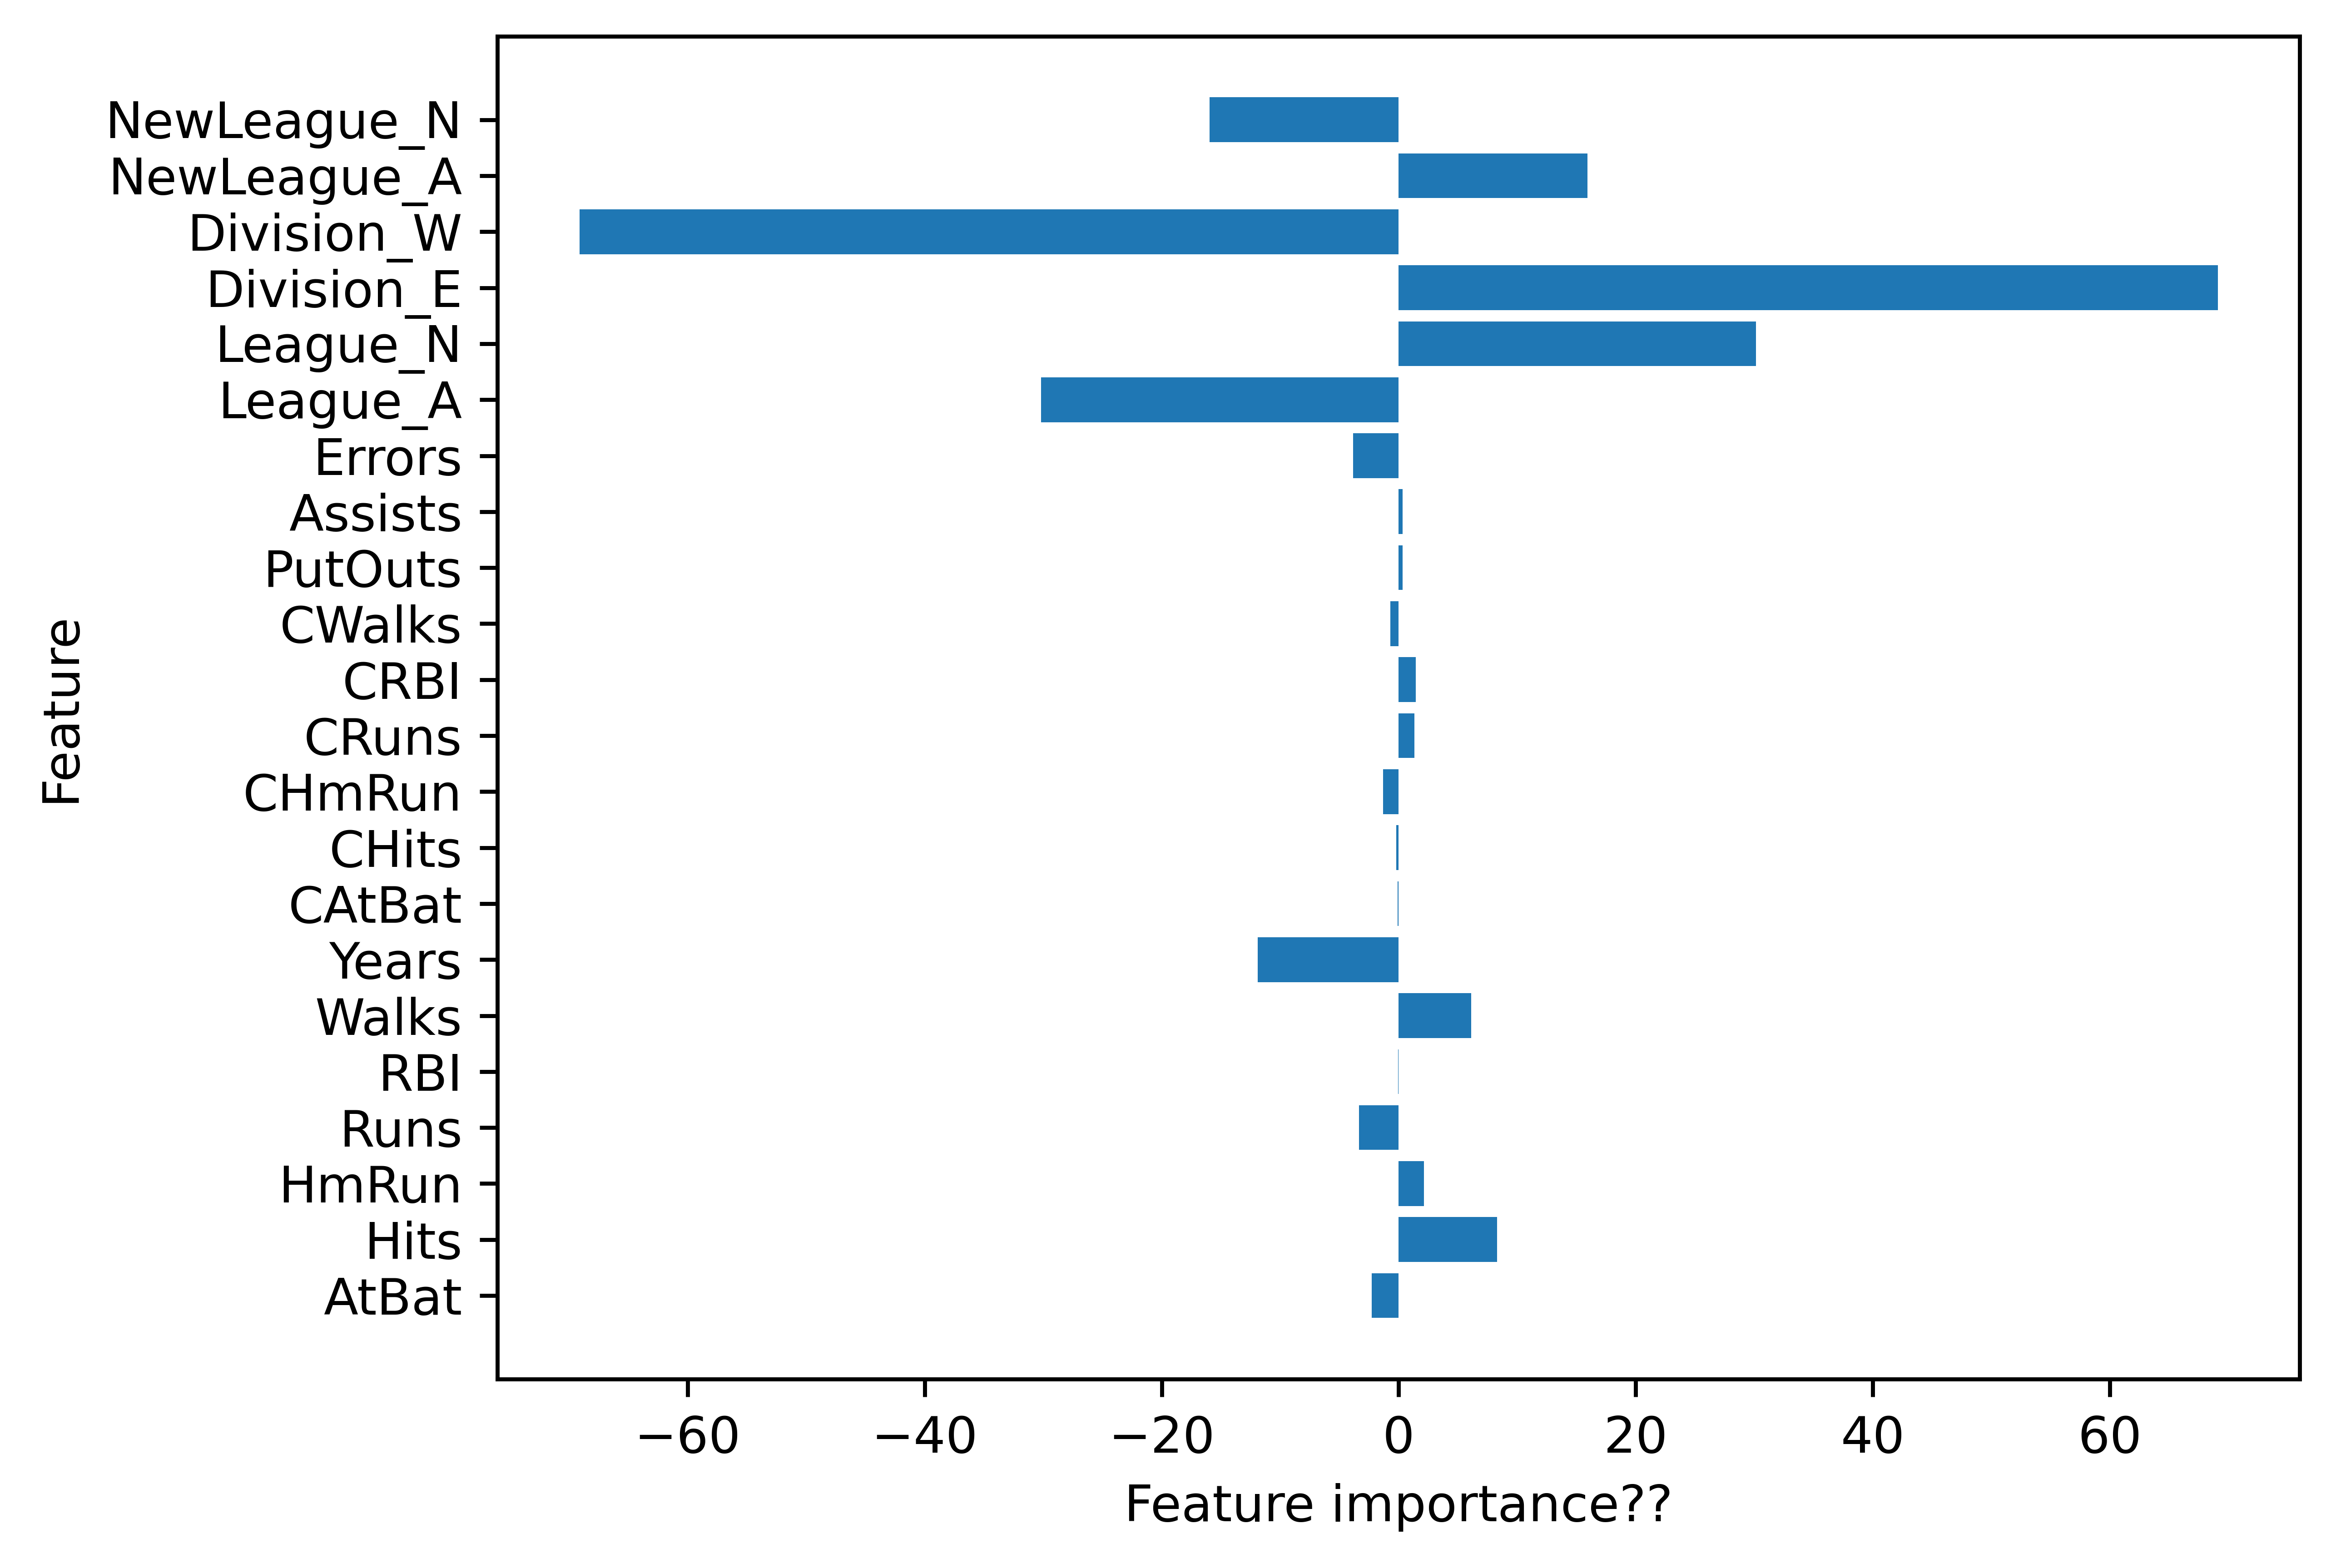

In [9]:
print("Intercept:", ols.intercept_)

n_features = len(ols.coef_)
plt.figure(dpi = 800)
plt.barh(range(n_features), ols.coef_, align='center')
plt.yticks(np.arange(n_features), X.columns)
plt.xlabel("Feature importance??")
plt.ylabel("Feature")

This data set needs cleaning something awful, but we'll do that later.

**Important:** Note how Division looks to be the most important feature by far. It isn't. This is just because Division is 0 or 1, where some of the others go into the thousands. In order to get comparable features, we need to _scale_.

### Scaling

The standard scaler scales all features to a mean of 0 and a standard deviation of 1 (so a variance of 1). The standard scaler is a _linear preprocessor_, so we use it to _transform_ data like below.

In [10]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = .2, random_state = 504)

The actual linear regression hasn't changed. Neither have the scores. This is to be expected: It's a _linear_ preprocessor and _linear_ regression.

In [11]:
ols.fit(X_train, y_train)

print("Score on train set = {0}, Score on test set = {1}".format(ols.score(X_train, y_train), ols.score(X_test, y_test)))

Score on train set = 0.5374392625579143, Score on test set = 0.5077891700376134


There is no reason to expect the scores to change. Everything is still linear. However, the coefficients sure have.

Intercept: 522.6387912978552


Text(0, 0.5, 'Feature')

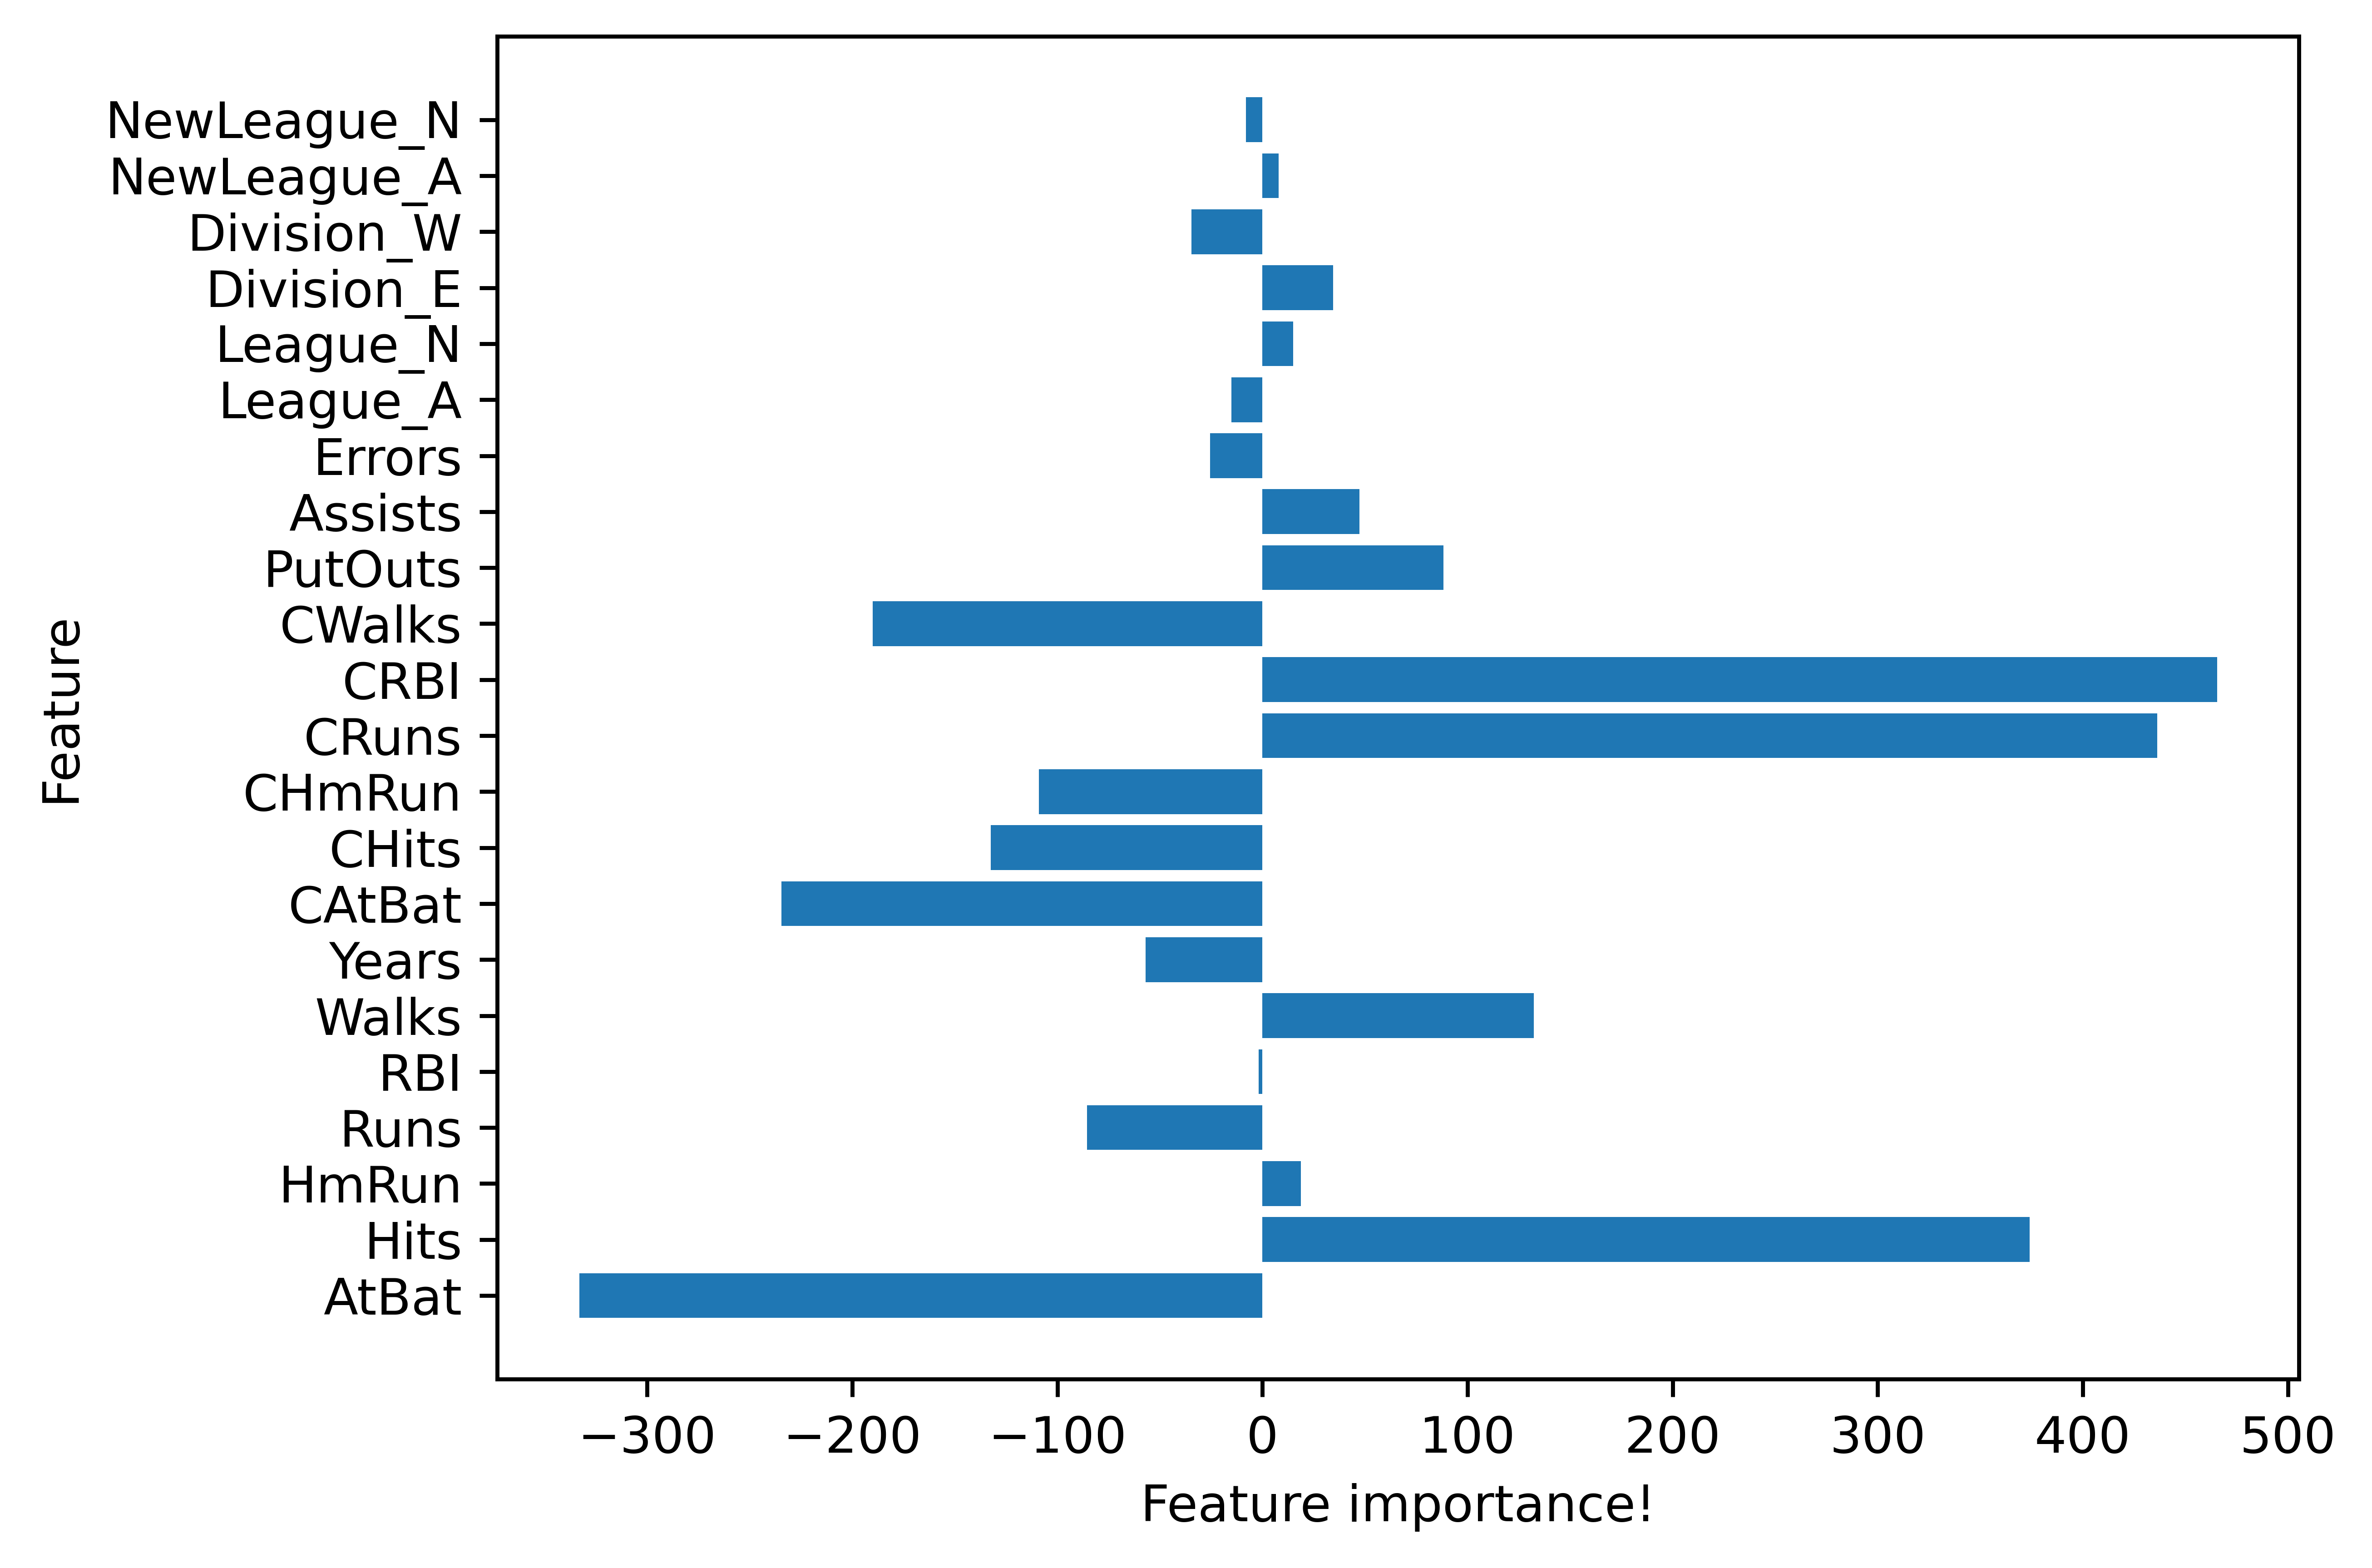

In [12]:
print("Intercept:", ols.intercept_)

n_features = len(ols.coef_)
plt.figure(dpi = 800)
plt.barh(range(n_features), ols.coef_, align='center')
plt.yticks(np.arange(n_features), X.columns)
plt.xlabel("Feature importance!")
plt.ylabel("Feature")

Think about: _Which of these features are suspect and what could we do about it?_

## Ridge regression

Ridge regression penalizes large coeffecients by a factor of α. **It is _very_ important that you scale your features before attempting ridge regression.** 

In [13]:
ridge_cv = RidgeCV(alphas = np.linspace(1, 10, 10))
ridge_cv.fit(X_train, y_train)
ridge_cv.alpha_

np.float64(7.0)

In [14]:
ridge = Ridge(alpha=8)

ridge.fit(X_train, y_train)

print("Score on train set = {0}, Score on test set = {1}".format(ridge.score(X_train, y_train), ridge.score(X_test, y_test)))

Score on train set = 0.5157958519712216, Score on test set = 0.4947629666580047


So Ridge didn't do any better (spoiler: Neither will Lasso), but that wasn't the point. Let's look at the coefficients.

Intercept: 524.2745182941583


Text(0, 0.5, 'Feature')

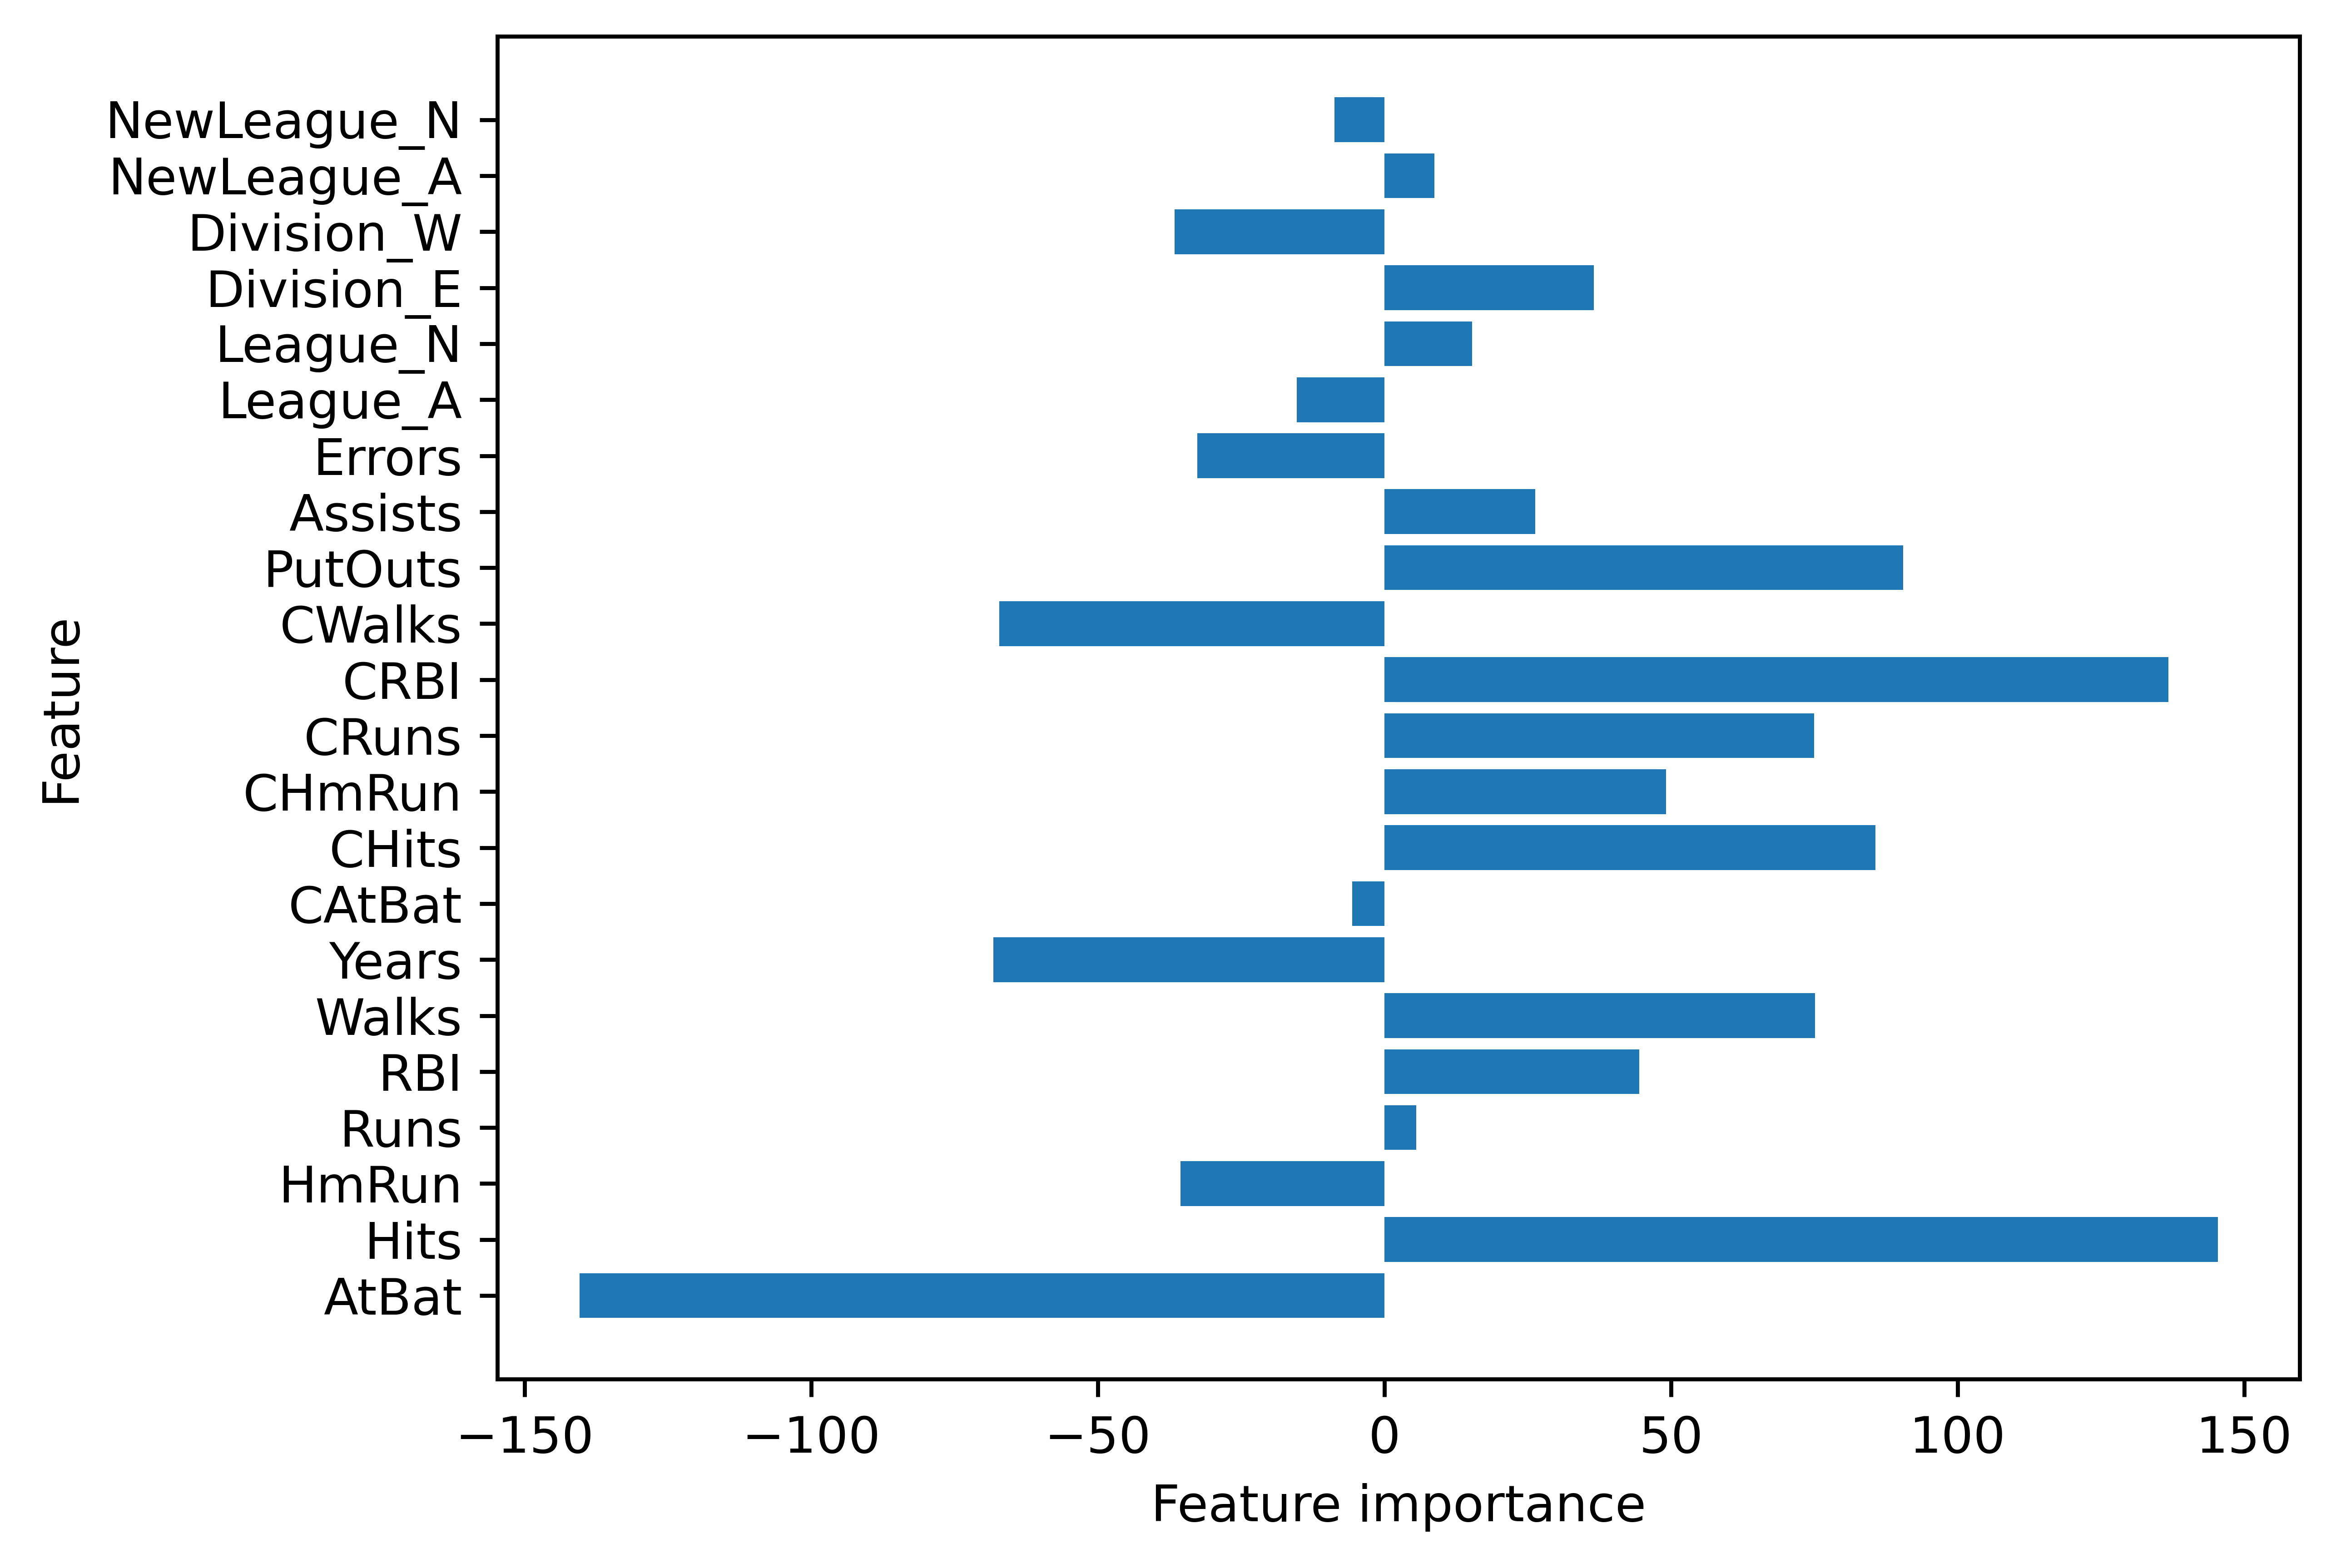

In [15]:
print("Intercept:", ridge.intercept_)

n_features = len(ridge.coef_)
plt.figure(dpi = 800)
plt.barh(range(n_features), ridge.coef_, align='center')
plt.yticks(np.arange(n_features), X.columns)
plt.xlabel("Feature importance")
plt.ylabel("Feature")

We can see that these are markedly smaller (note the scale on the x-axis). They are not 0, though. This is because θ<sup>2</sup> favors small numbers enough that there is no reason to drive it all the way to 0.

## Lasso

We do the same as above, just replace Ridge with Lasso.

In [16]:
lasso_cv = LassoCV(alphas = np.linspace(1, 40, 100))
lasso_cv.fit(X_train, y_train)
lasso_cv.alpha_

np.float64(16.363636363636363)

In [17]:
lasso = Lasso(alpha=16.3)

lasso.fit(X_train, y_train)

print("Score on train set = {0}, Score on test set = {1}".format(lasso.score(X_train, y_train), lasso.score(X_test, y_test)))

Score on train set = 0.4754110156245446, Score on test set = 0.4652276238364068


The interesting part is the coefficients.

Intercept: 526.0690738130866


Text(0, 0.5, 'Feature')

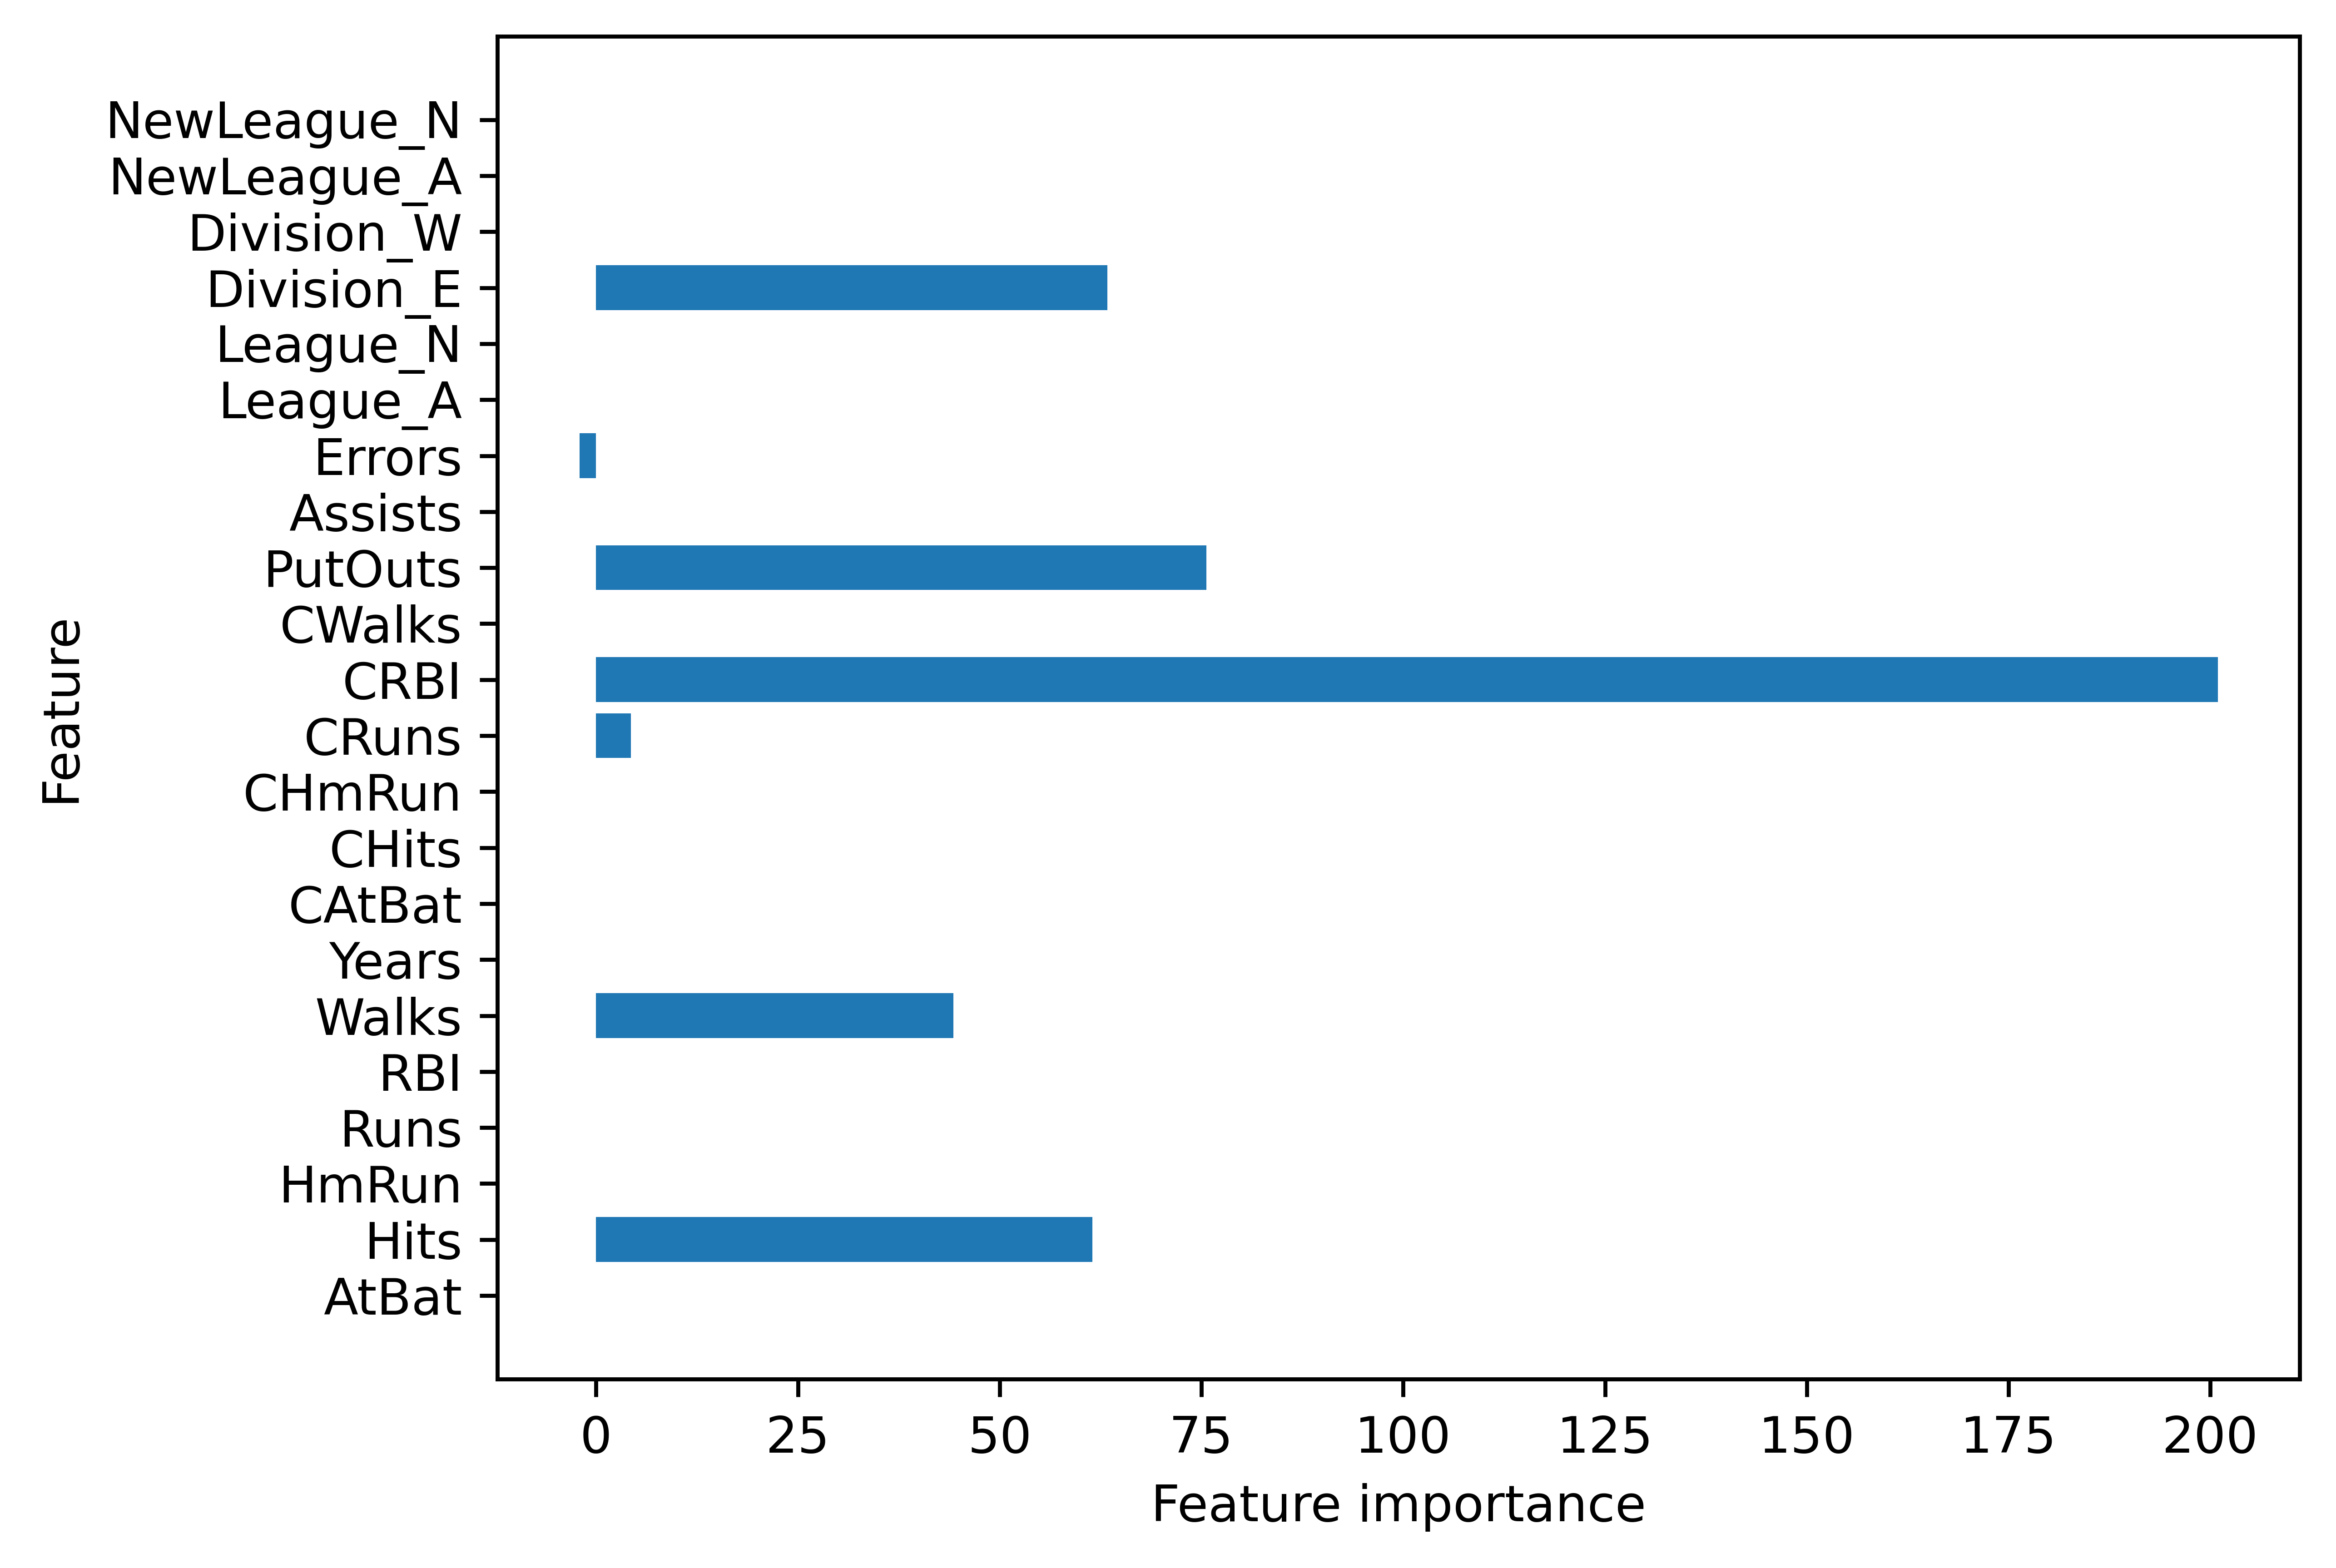

In [18]:
print("Intercept:", lasso.intercept_)

n_features = len(lasso.coef_)
plt.figure(dpi = 800)
plt.barh(range(n_features), lasso.coef_, align='center')
plt.yticks(np.arange(n_features), X.columns)
plt.xlabel("Feature importance")
plt.ylabel("Feature")

Look at all the zeroes!